# Prediction: Thickness of melting zone

### Import of the dataset

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('/Users/tobias/PycharmProjects/melting-zone-thickness-prediction/data/welding_data.csv',
                  sep=',',
                  decimal=',',
                  thousands='.')
data = data.astype(dtype={'Nennleistung / W': np.float64, 'd_f / mm': np.float64, 'λ_K / W/(m*K)': np.float64,
                          'c_p_K / J/(kg*K)': np.float64, 'ρ_K / kg/m^3': np.float64, 'H_s_K / kJ/kg': np.float64,
                          'T_im_K / °C': np.float64, 't_M / mm': np.float64, 'λ_M / W/(m*K)': np.float64,
                          'c_p_M / J/(kg*K)': np.float64, 'ρ_M / kg/m^3': np.float64})
y = 'Schmelzzonendicke / µm'
features = ['Fügezeit', 'Nennleistung / W', 'd_f / mm', 'λ_K / W/(m*K)', 'c_p_K / J/(kg*K)', 'ρ_K / kg/m^3', 'H_s_K / kJ/kg', 'T_im_K / °C', 't_M / mm', 'λ_M / W/(m*K)', 'c_p_M / J/(kg*K)', 'ρ_M / kg/m^3']

### Calculation of Realleistung

In [2]:
data['Realleistung'] = (data['Nennleistung / W']*data['ρ_M / kg/m^3'])/1000
#data.drop(labels=['Nennleistung / W', 'ρ_M / kg/m^3'], inplace=True, axis=1)

In [3]:
train_data = data[data['data_type']=='train']
validation_data = data[data['data_type']=='validation']

### Visualization of data

Populating the interactive namespace from numpy and matplotlib


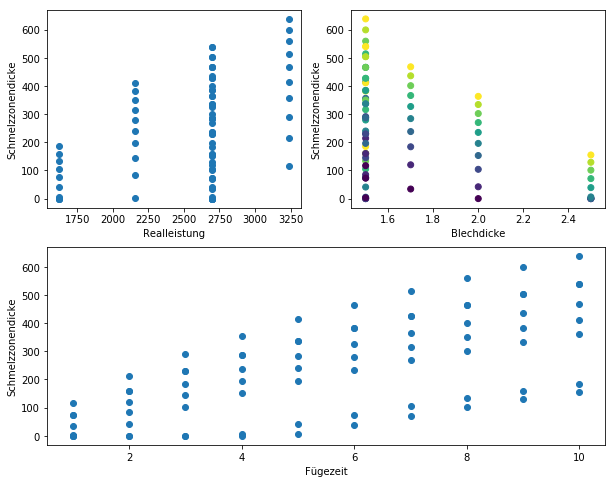

In [4]:
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 8)

#plt.title('Realleistung, Fügezeit und Blechdicke über Schmelzzonendicke')
plt.subplot(221)
plt.scatter(x=train_data['Realleistung'], y=train_data[y])
plt.xlabel('Realleistung')
plt.ylabel('Schmelzzonendicke')
plt.subplot(212)
plt.scatter(x=train_data['Fügezeit'], y=train_data[y])
plt.xlabel('Fügezeit')
plt.ylabel('Schmelzzonendicke')
plt.subplot(222)
plt.scatter(x=train_data['t_M / mm'], y=train_data[y], c=train_data['Fügezeit'])
plt.xlabel('Blechdicke')
plt.ylabel('Schmelzzonendicke')
plt.show()

Text(0, 0.5, 'Schmelzzonendicke')

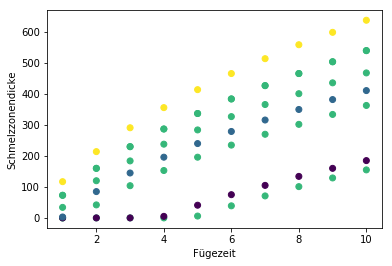

In [5]:
plt.scatter(x=train_data['Fügezeit'], y=train_data[y], c=train_data['Realleistung'])
plt.xlabel('Fügezeit')
plt.ylabel('Schmelzzonendicke')

Text(0, 0.5, 'Schmelzzonendicke')

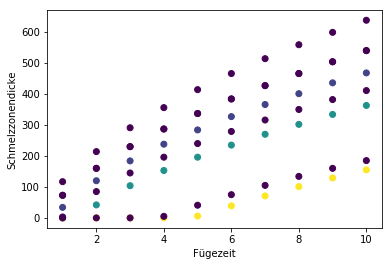

In [6]:
plt.scatter(x=train_data['Fügezeit'], y=train_data[y], c=train_data['t_M / mm'])
plt.xlabel('Fügezeit')
plt.ylabel('Schmelzzonendicke')

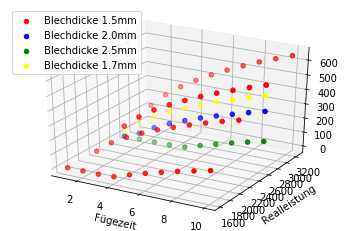

In [7]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
color = ['red', 'blue', 'green', 'yellow']


blechdicken = list(set(train_data['t_M / mm']))

i=0
for blechdicke in blechdicken:
    data = train_data[train_data['t_M / mm']==blechdicke]
    ax.scatter(xs=data['Fügezeit'], zs=data[y], ys=data['Realleistung'], c=color[i], label=data['t_M / mm'])
    plt.xlabel('Fügezeit')
    plt.ylabel('Realleistung')
    blechdicken[i] = 'Blechdicke ' + str(blechdicken[i]) + 'mm'
    i+=1


    
ax.legend(blechdicken)
plt.show()

### Data Cleaning

In [8]:
train_data = train_data[train_data[y]>0]

### Preprocessing

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_data[features])

X_train = scaler.transform(train_data[features])
y_train = train_data[y]

## Linear Regression

### Training

In [10]:
from sklearn.linear_model import LinearRegression

linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train, y_train)
print(linear_regression_model.coef_)

[ 404.42032975  371.38198298    0.            0.            0.
    0.            0.            0.         -314.19119973    0.
    0.            0.        ]


In [11]:
from sklearn.metrics import mean_absolute_error as mae

y_pred = linear_regression_model.predict(X_train)
print("Linear Regression - Mean Absolute Error:", mae(y_pred=y_pred, y_true=y_train))

Linear Regression - Mean Absolute Error: 30.519531906455214


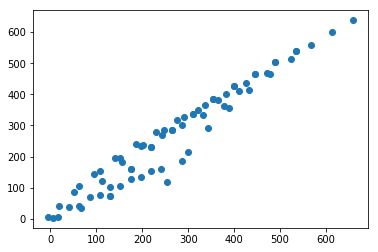

In [12]:
import matplotlib.pyplot as plt

y_pred = linear_regression_model.predict(X_train)
plt.scatter(y_pred, y_train)
plt.show()

## Support Vector Regression

In [13]:
from sklearn.preprocessing import minmax_scale

#y_train = minmax_scale(y_train)

### Grid Search with Cross Validation

In [14]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

param_grid = {'kernel': ['poly', 'rbf', 'sigmoid', 'linear'],
             'degree': [2, 3, 5],
              'coef0': [0.0],
             'gamma': ['auto'],
             'C': [0.1, 0.5, 1.0, 2.0],
             'epsilon': [0.01, 0.05, 0.1, 0.3]}

welding_thickness_grid_search_cv = GridSearchCV(estimator=SVR(),
                                                param_grid=param_grid,
                                                cv=3,
                                                n_jobs=-1)

welding_thickness_grid_search_cv_fitted = welding_thickness_grid_search_cv.fit(X_train, y_train)
welding_thickness_predictor = welding_thickness_grid_search_cv_fitted.best_estimator_
print("Best score:", -welding_thickness_grid_search_cv_fitted.best_score_)
print("Parameters:", welding_thickness_predictor)

Best score: 0.19511852072741784
Parameters: SVR(C=2.0, cache_size=200, coef0=0.0, degree=2, epsilon=0.01, gamma='auto',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [15]:
from sklearn.metrics import mean_absolute_error as mae

y_pred = welding_thickness_predictor.predict(X_train)
print("Support Vector Regression - Mean Absolute Error:", mae(y_pred=y_pred, y_true=y_train))

Support Vector Regression - Mean Absolute Error: 133.2835356652949


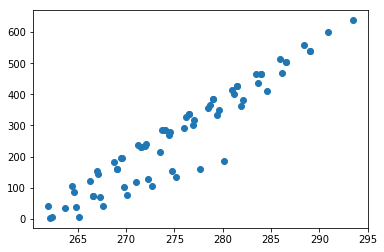

In [16]:
import matplotlib.pyplot as plt

y_pred = welding_thickness_predictor.predict(X_train)
plt.scatter(y_pred, y_train)
plt.show()